# Tutorial 4 - Tackling Individual Differences with Participant Embeddings

By talking about individual differences, cognitive scientists are referring to individual notions in exhibited behavior, e.g. different learning rates.

As a simplified case, we are going to collect data from two participants with two individual learning rates. Then, we try to recover them once with the last RNN (learning rate with hardcoded equations for the reward prediction error, precoded) and a version which implements a participant-embedding layer. As usual, we first use the precoded model and then show how to implement it.

<!-- 
But this thought can go even deeper if we not only consider different parameterizations for each participant but also different model architectures for each participant!

Think of the following scenario: 

One participant exhibits only goal-directed behavior (i.e. making choices based only on the reward-based values) while another participant shows an additional positivity bias (i.e. increasing the learning rate for positive outcomes while the value is low and a decreasing the learning rate for negative outcomes while the value is high). Such a positivity bias can help to account for reward volatility, by preventing to drastic value updates in the case of an unexpected penalty ($reward = 0$). Additionally, it can also induce goal-directed exploration by making more drastic updates in the case of an unexpected reward.  -->

<!-- But that's enough theory for now. Let's get our hands dirty again! -->

## 1. Data generation

First of all we have to generate a dataset with multiple participants. Let's start with two different ones.

We are going generate half the dataset with participant #1 and the other half with participant #2.

In [1]:
import numpy as np
import torch

np.random.seed(42)
torch.manual_seed(42)

In [2]:
from spice.resources.bandits import BanditsDrift, AgentQ, create_dataset
from spice.resources.rnn_utils import DatasetRNN

# Set up the environment
n_actions = 2
sigma = 0.2

environment = BanditsDrift(sigma=sigma, n_actions=n_actions)

# Set up the agents
# participant #1
agent_1 = AgentQ(
    n_actions=n_actions,
    alpha_reward=0.8  # Higher learning rate for participant #1
)

# participant #2
agent_2 = AgentQ(
    n_actions=n_actions,
    alpha_reward=0.2,  # Lower learning rate for participant #2
)

# Create the dataset
n_trials = 200
n_sessions = 256

dataset_1, _, _ = create_dataset(
    agent=agent_1,
    environment=environment,
    n_trials=n_trials,
    n_sessions=n_sessions//2,  # Generate half the dataset with participant #1
)

# change the participant id of all sessions to 0
dataset_1.xs[..., -1] = 0

dataset_2, _, _ = create_dataset(
    agent=agent_2,
    environment=environment,
    n_trials=n_trials,
    n_sessions=n_sessions//2,  # Generate the other half with participant #2
)

# Set the participant id of all sessions to 1
dataset_2.xs[..., -1] = 1

# Combine the two datasets
dataset_xs = torch.cat((dataset_1.xs, dataset_2.xs))
dataset_ys = torch.cat((dataset_1.ys, dataset_2.ys))
dataset = DatasetRNN(dataset_xs, dataset_ys)

print(f'Shape of the new dataset: {dataset.xs.shape}')
print(f'Number of participants: {len(dataset.xs[..., -1].unique())}')

/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Creating dataset...


100%|██████████| 128/128 [00:00<00:00, 167.47it/s]


Creating dataset...


100%|██████████| 128/128 [00:00<00:00, 165.25it/s]

Shape of the new dataset: torch.Size([256, 200, 5])
Number of participants: 2


Let's see how different these two participants behave.

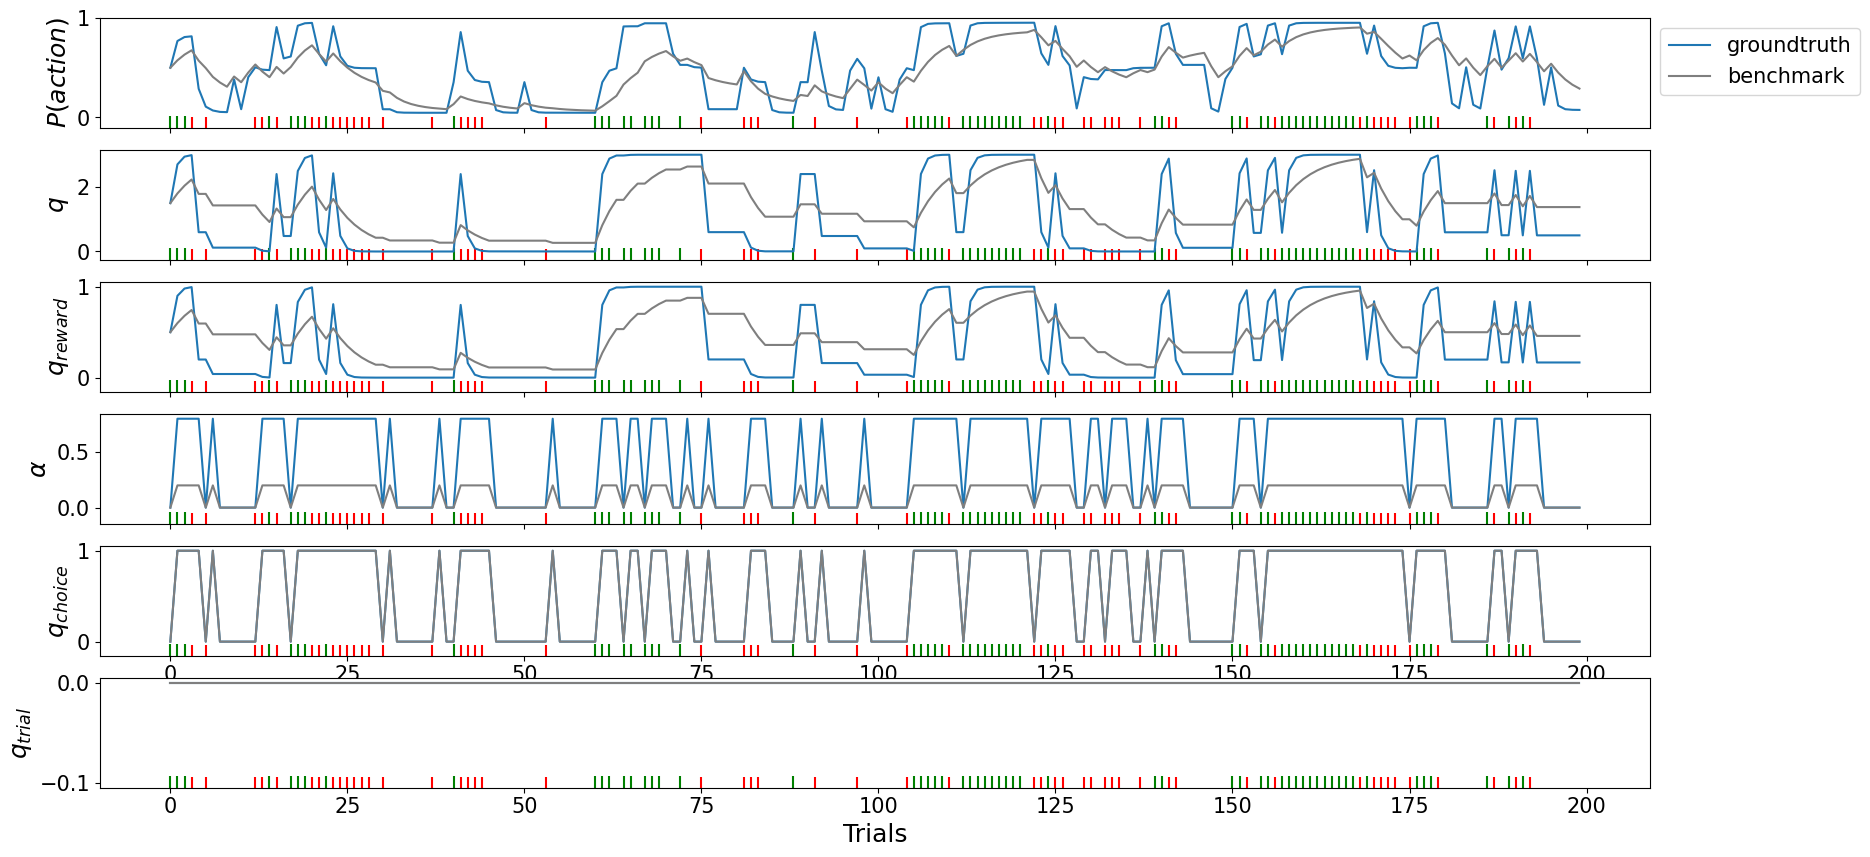

In [3]:
from spice.utils.plotting import plot_session
import matplotlib.pyplot as plt

agents = {'groundtruth': agent_1, 'benchmark': agent_2}
fig, axs = plot_session(agents, dataset.xs[0])

plt.show()

## 2. Using the previous model without participant information

Let's inspect first how our last RNN (precoded `LearningRateRNN`) would perform in such a situation to verify the need for tackling individual differences with a participant-embedding layer.

In [7]:
from spice.estimator import SpiceEstimator
from spice.precoded import LearningRateRNN, LEARNING_RATE_RNN_CONFIG

spice_estimator = SpiceEstimator(
    rnn_class=LearningRateRNN,
    spice_config=LEARNING_RATE_RNN_CONFIG,
    learning_rate=5e-3,
    epochs=1024,
    n_steps_per_call=16,
    convergence_threshold=0,
    scheduler=True,
    spice_optim_threshold=0.05,
    spice_optim_regularization=0.1,
    spice_participant_id=0,
    verbose=True,
)

spice_estimator.fit(dataset.xs, dataset.ys)


Training the RNN...
Epoch 1/1024 --- L(Train): 0.8553782; Time: 0.11s; Convergence: 5.72e-01; LR: 0.00e+00
Epoch 2/1024 --- L(Train): 0.7695565; Time: 0.09s; Convergence: 3.29e-01; LR: 7.81e-04
Epoch 3/1024 --- L(Train): 0.7465485; Time: 0.10s; Convergence: 1.76e-01; LR: 1.56e-03
Epoch 4/1024 --- L(Train): 0.7142327; Time: 0.09s; Convergence: 1.04e-01; LR: 2.34e-03
Epoch 5/1024 --- L(Train): 0.6796729; Time: 0.09s; Convergence: 6.94e-02; LR: 3.13e-03
Epoch 6/1024 --- L(Train): 0.6488071; Time: 0.09s; Convergence: 5.01e-02; LR: 3.91e-03
Epoch 7/1024 --- L(Train): 0.6247658; Time: 0.09s; Convergence: 3.71e-02; LR: 4.69e-03
Epoch 8/1024 --- L(Train): 0.6080493; Time: 0.09s; Convergence: 2.69e-02; LR: 5.47e-03
Epoch 9/1024 --- L(Train): 0.5974948; Time: 0.09s; Convergence: 1.87e-02; LR: 6.25e-03
Epoch 10/1024 --- L(Train): 0.5912980; Time: 0.09s; Convergence: 1.25e-02; LR: 7.03e-03
Epoch 11/1024 --- L(Train): 0.5877612; Time: 0.09s; Convergence: 8.00e-03; LR: 7.81e-03
Epoch 12/1024 --- L(

  0%|          | 0/1 [00:00<?, ?it/s]


SINDy model for x_learning_rate_reward:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 4.0235e+00 ... 1.0000e-01 ... 1.7471e-02 ... 4.0510e+00
        10 ... 4.0345e+00 ... 1.0000e-01 ... 1.6921e-02 ... 4.0614e+00
(x_learning_rate_reward)[k+1] = 0.113 1 + 0.338 x_learning_rate_reward[k] + 0.160 c_reward[k] + 0.088 c_value_reward[k]

SINDy model for x_value_reward_not_chosen:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 7.6122e-03 ... 2.5260e-02 ... 2.4491e-02 ... 3.4629e-02
(x_value_reward_not_chosen)[k+1] = 0.968 x_value_reward_not_chosen[k]


100%|██████████| 1/1 [00:00<00:00,  2.06it/s]

SPICE training finished.
Training took 100.12 seconds.


Let's inspect the predictions for participant #1.

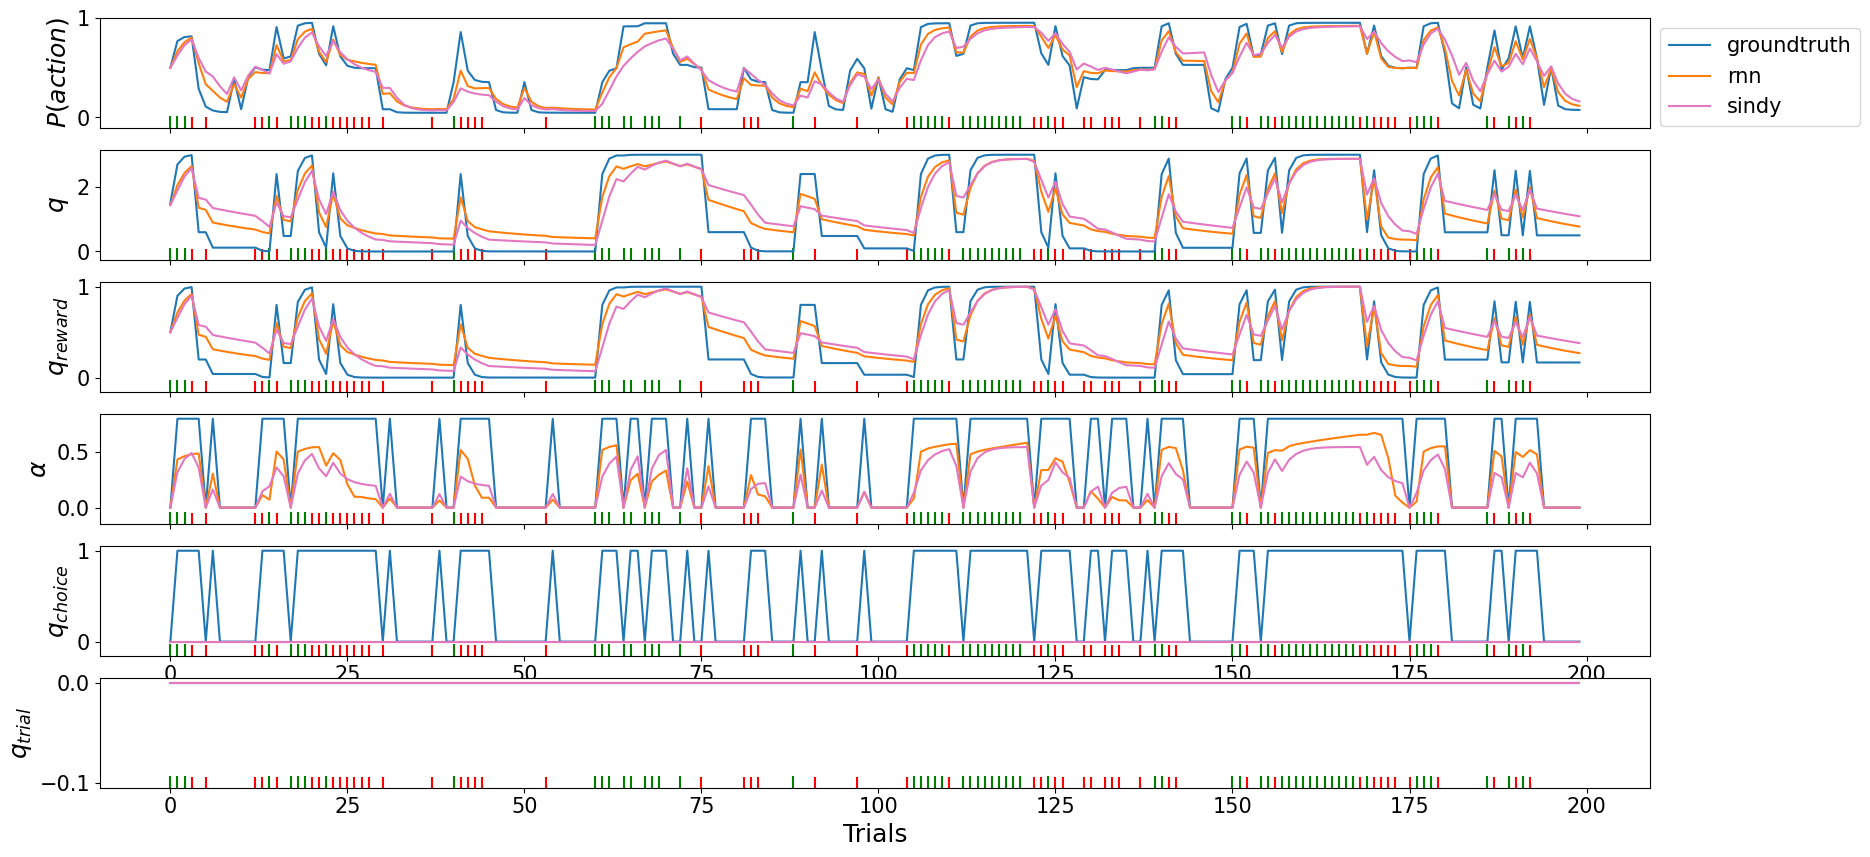

In [8]:
# get analysis plot
agents = {'groundtruth': agent_1, 'rnn': spice_estimator.rnn_agent, 'sindy': spice_estimator.spice_agent}
fig, axs = plot_session(agents, dataset_1.xs[0])
plt.show()

And now for participant #2.

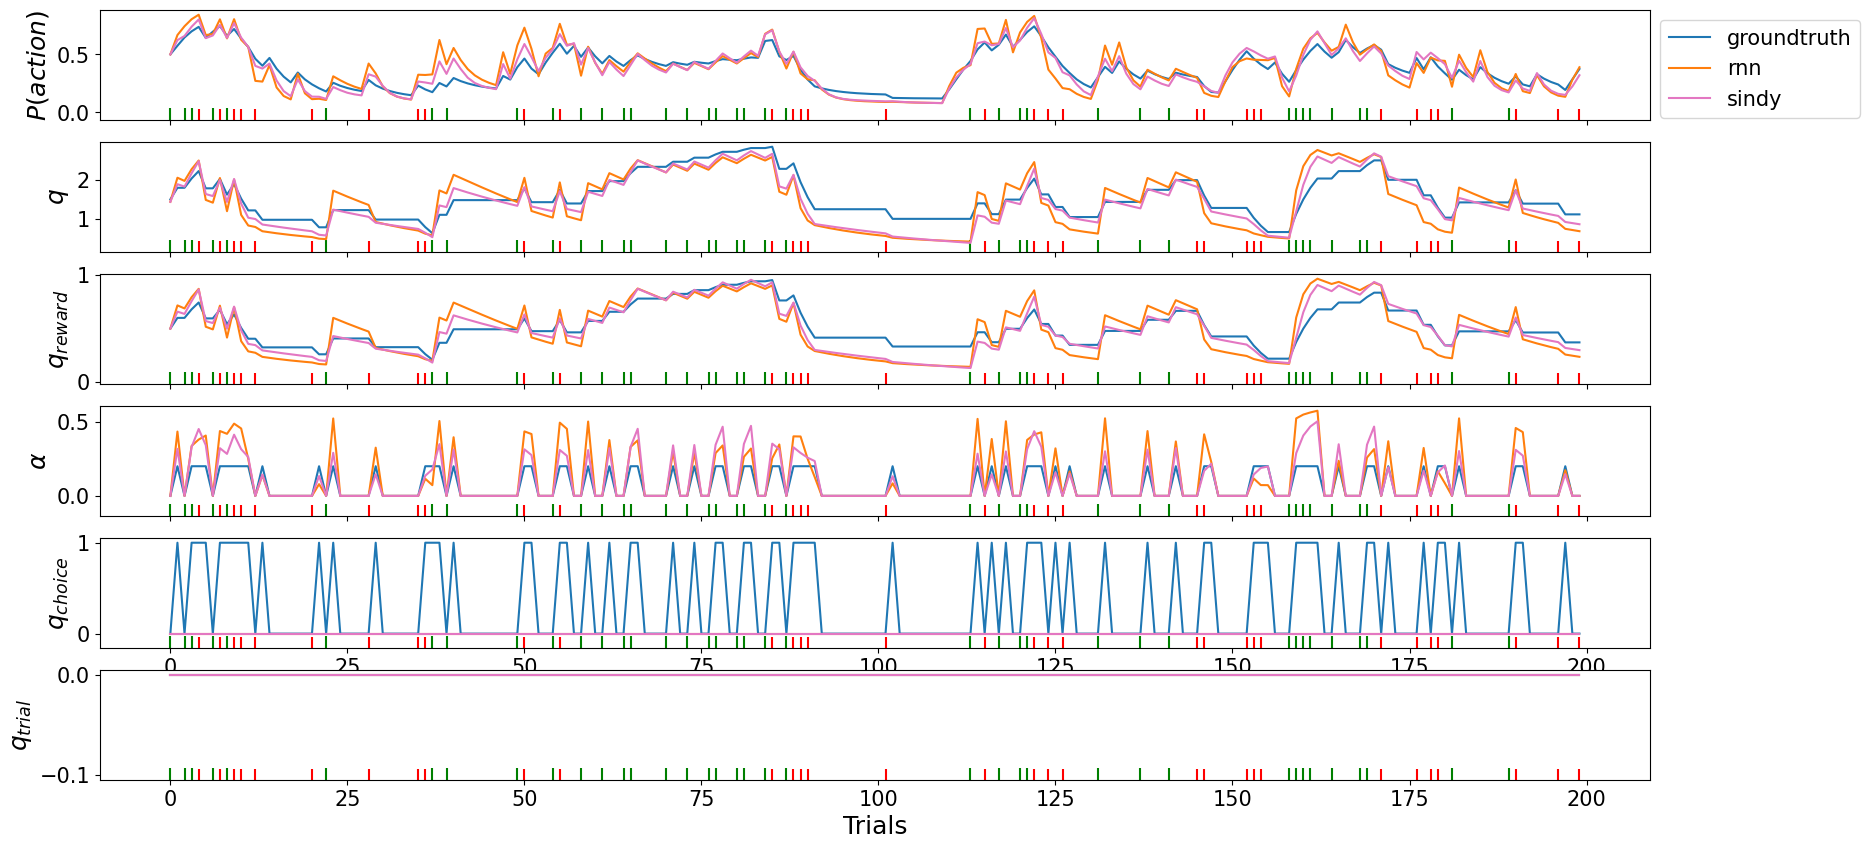

In [9]:
agents = {'groundtruth': agent_2, 'rnn': spice_estimator.rnn_agent, 'sindy': spice_estimator.spice_agent}
fig, axs = plot_session(agents, dataset_2.xs[0])
plt.show()

The fit across both participants is  worse compared to the other use-cases, where we had only one participant to fit. 

Therefore, we can definitely see the need for modeling individual differences - already in this case. The need is even stronger for real datasets with dozens of participants.  

Let's implement now a RNN which can be trained on the whole dataset but account for the differences in the individuals' behavior.

For that we are going to add a participant-embedding layer. It works similar to e.g. word-embeddings which translate a one-hot encoded vector into a dense representation in a multidimensional space.

The one-hot encoded vector corresponds to e.g. a dictionary marking the index of a certain word. After translating this word into the multidimensional space, researchers can do inference on word similarity or try to interpret the representation and extract characteristics from it.

We are making use of the embedding layer by passing a unique participant id into it and retrieve a dense representation of this participant. Afterwards we can feed this representation to the RNN-modules or compute individual noise temperatures.

That way the RNN-modules can learn *(theoretically)* any type of cognitive mechanism present in the data across all participants and the participant-embedding can give the individual notions to them by e.g. switching mechanisms on and off and parameterizing them.

## 3. Incorporating Participant Embeddings

Now we will use the precoded model with support for participant embeddings, before implementing it ourselves.

As you can imagine the individual differences can be quite subtle. Unlike big architectural differences, individual differences have to be fitted very cautiously, i.e. in the machine learning context with a very low learning rate.

Low learning rates have a couple of disadvantages, i.e. (1) they take very long to converge, and (2) they can get stuck easily in local minima. 

These are the reasons why we should use a learning rate scheduler in this scenario. The implemented learning rate scheduler can be activated in the fitting method by setting `scheduler=True`. This way we are making use of a learning rate scheduler which adjusts the learning rate dynamically.

In [11]:
from spice.estimator import SpiceEstimator
from spice.precoded import ParticipantEmbeddingRNN, LEARNING_RATE_RNN_CONFIG

# Get the number of participants from data
participant_ids = dataset.xs[..., -1].unique()
n_participants = len(participant_ids)

spice_estimator = SpiceEstimator(
    rnn_class=ParticipantEmbeddingRNN,
    spice_config=LEARNING_RATE_RNN_CONFIG,  # Same config as before
    learning_rate=5e-3,
    epochs=1024,
    n_participants=n_participants,
    n_actions=n_actions,
    n_steps_per_call=16,
    convergence_threshold=0,
    scheduler=True,
    spice_optim_threshold=0.05,
    spice_optim_regularization=0.1,
    spice_participant_id=None,
    verbose=True,
)

spice_estimator.fit(dataset.xs, dataset.ys)


Training the RNN...
Epoch 1/1024 --- L(Train): 0.6968615; Time: 0.12s; Convergence: 6.52e-01; LR: 0.00e+00
Epoch 2/1024 --- L(Train): 0.6931473; Time: 0.12s; Convergence: 3.28e-01; LR: 7.81e-04
Epoch 3/1024 --- L(Train): 0.6931473; Time: 0.12s; Convergence: 1.64e-01; LR: 1.56e-03
Epoch 4/1024 --- L(Train): 0.6931473; Time: 0.12s; Convergence: 8.19e-02; LR: 2.34e-03
Epoch 5/1024 --- L(Train): 0.6931473; Time: 0.12s; Convergence: 4.10e-02; LR: 3.13e-03
Epoch 6/1024 --- L(Train): 0.6931473; Time: 0.12s; Convergence: 2.05e-02; LR: 3.91e-03
Epoch 7/1024 --- L(Train): 0.6931473; Time: 0.11s; Convergence: 1.02e-02; LR: 4.69e-03
Epoch 8/1024 --- L(Train): 0.6931473; Time: 0.12s; Convergence: 5.12e-03; LR: 5.47e-03
Epoch 9/1024 --- L(Train): 0.6931473; Time: 0.12s; Convergence: 2.56e-03; LR: 6.25e-03
Epoch 10/1024 --- L(Train): 0.6931473; Time: 0.11s; Convergence: 1.28e-03; LR: 7.03e-03
Epoch 11/1024 --- L(Train): 0.6931473; Time: 0.20s; Convergence: 6.40e-04; LR: 7.81e-03
Epoch 12/1024 --- L(

  0%|          | 0/2 [00:00<?, ?it/s]


SINDy model for x_learning_rate_reward:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 1.1898e-01 ... 8.4237e-02 ... 2.2151e-02 ... 1.4956e-01
(x_learning_rate_reward)[k+1] = 0.692 1 + 0.076 c_reward[k] + 0.069 c_value_reward[k]

SINDy model for x_value_reward_not_chosen:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 4.7989e-06 ... 2.5356e-02 ... 2.4957e-02 ... 2.7498e-02
(x_value_reward_not_chosen)[k+1] = 0.999 x_value_reward_not_chosen[k]


 50%|█████     | 1/2 [00:00<00:00,  1.57it/s]


SINDy model for x_learning_rate_reward:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 1.7790e-03 ... 5.7973e-02 ... 5.7371e-03 ... 1.3313e-02
(x_learning_rate_reward)[k+1] = 0.196 1

SINDy model for x_value_reward_not_chosen:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 3.6620e-06 ... 2.5100e-02 ... 2.4877e-02 ... 2.7390e-02
(x_value_reward_not_chosen)[k+1] = 0.996 x_value_reward_not_chosen[k]


100%|██████████| 2/2 [00:01<00:00,  1.68it/s]

SPICE training finished.
Training took 124.57 seconds.


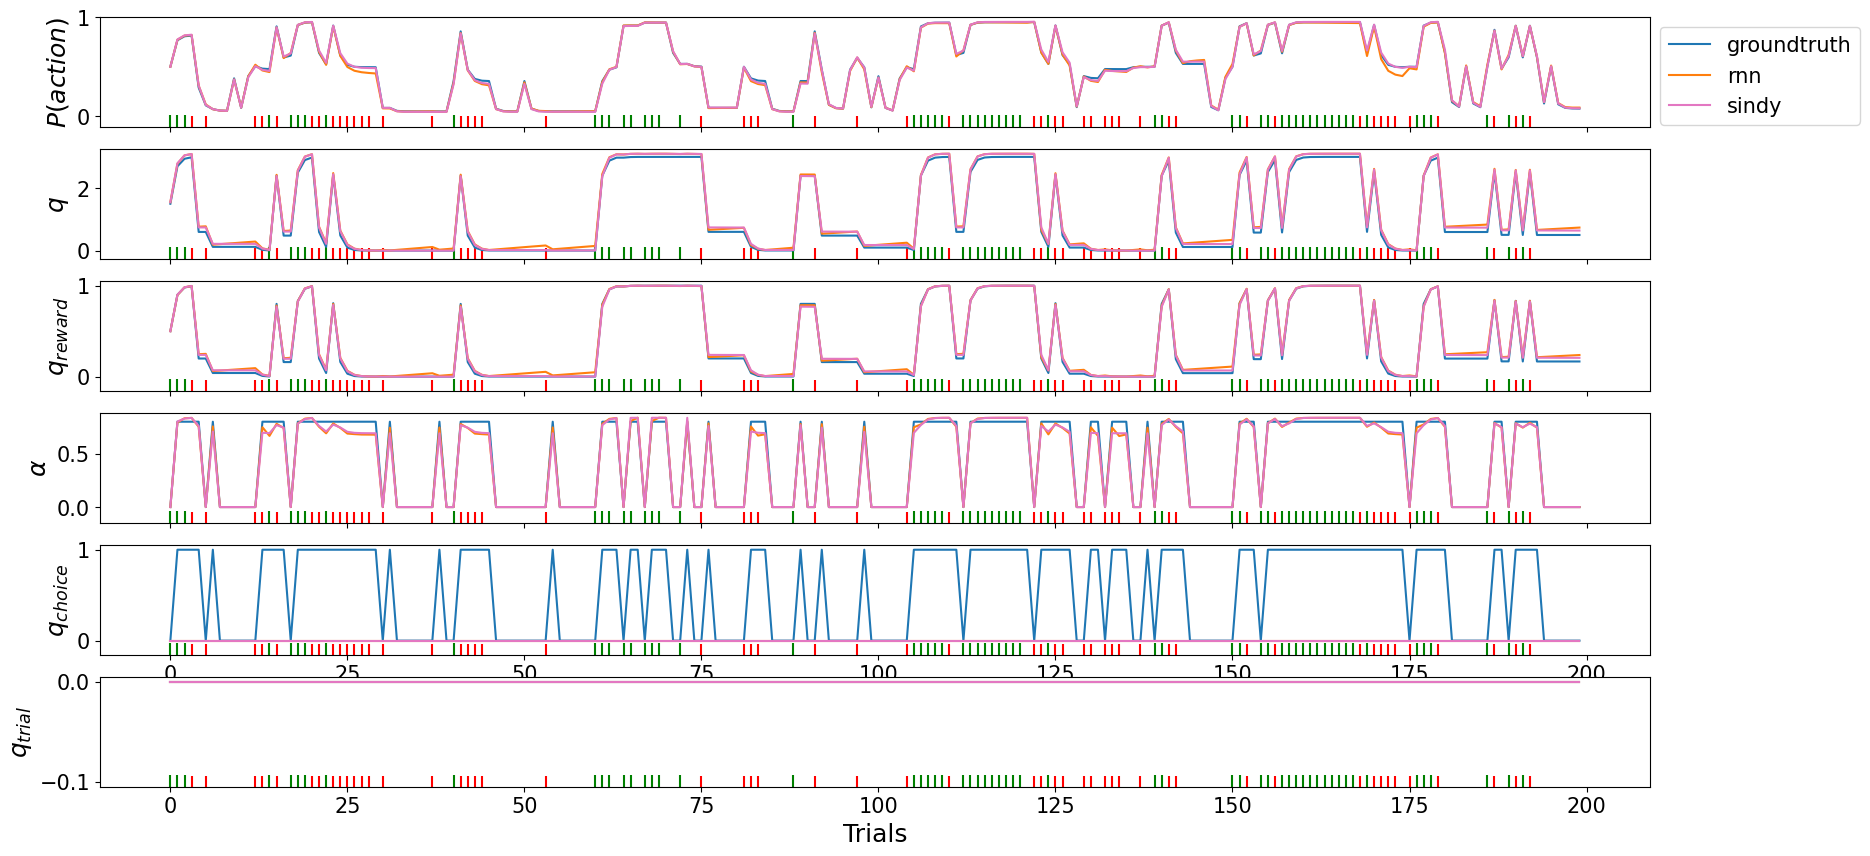

In [12]:
from spice.utils.plotting import plot_session

# get analysis plot
agents = {'groundtruth': agent_1, 'rnn': spice_estimator.rnn_agent, 'sindy': spice_estimator.spice_agent}
fig, axs = plot_session(agents, dataset_1.xs[0])
plt.show()

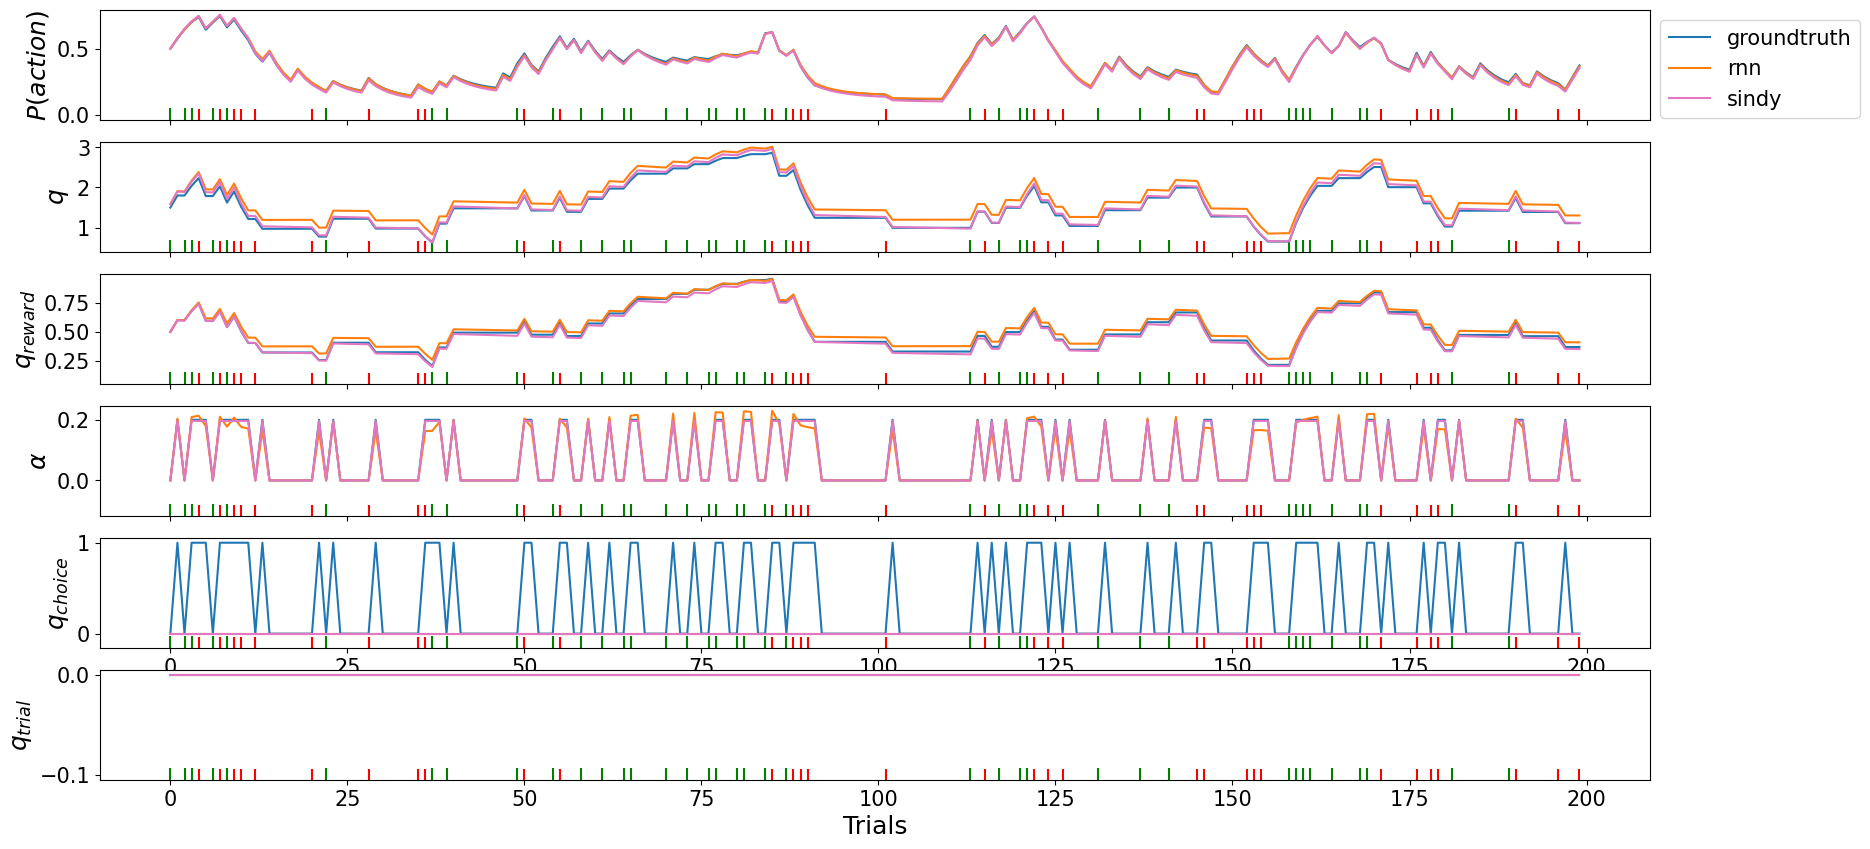

In [13]:
from spice.utils.plotting import plot_session

# get analysis plot
agents = {'groundtruth': agent_2, 'rnn': spice_estimator.rnn_agent, 'sindy': spice_estimator.spice_agent}
fig, axs = plot_session(agents, dataset_2.xs[0])
plt.show()

## 4. Implementing the RNN as a custom module

Now, we are going to implement the RNN with participant embeddings. This will be the same as the learning rate RNN implemented in the previous tutorial, with an additional embedding layer for participant IDs.

In [15]:
from spice.resources.rnn import BaseRNN
from spice.estimator import SpiceConfig


# Same config as before
CUSTOM_RNN_CONFIG = SpiceConfig(
    rnn_modules=['x_learning_rate_reward', 'x_value_reward_not_chosen'],
    
    control_parameters=['c_action', 'c_reward', 'c_value_reward'],

    library_setup={
        'x_learning_rate_reward': ['c_reward', 'c_value_reward'],
        'x_value_reward_not_chosen': [],
    },

    filter_setup={
        'x_learning_rate_reward': ['c_action', 1, True],
        'x_value_reward_not_chosen': ['c_action', 0, True],
    },
)

class CustomRNN(BaseRNN):
    
    init_values = {
            'x_value_reward': 0.5,
            'x_learning_rate_reward': 0,
        }
    
    def __init__(
        self,
        n_actions,
        # add an additional inputs to set the number of participants in your data
        n_participants,
        list_signals,
        **kwargs,
    ):
        
        super(CustomRNN, self).__init__(n_actions=n_actions, list_signals=list_signals)
        
        # Additional embedding layer for participant information
        self.embedding_size = 8
        self.participant_embedding = torch.nn.Embedding(num_embeddings=n_participants, embedding_dim=self.embedding_size)
        
        # and now we are adding for each participant a scaling factor (inverse noise temperature).
        # but this time, we want to use the participant embedding as an input
        self.betas = torch.nn.ModuleDict()
        self.betas['x_value_reward'] = torch.nn.Sequential(torch.nn.Linear(self.embedding_size, 1), torch.nn.ReLU())
        
        # and here we specify the general architecture
        # add to the input_size the embedding_size as well because we are going to pass the participant-embedding to the RNN-modules
        # set up the submodules
        self.submodules_rnn['x_learning_rate_reward'] = self.setup_module(input_size=2+self.embedding_size, dropout=0.)
        self.submodules_rnn['x_value_reward_not_chosen'] = self.setup_module(input_size=0+self.embedding_size, dropout=0.)
        
        # set up hard-coded equations
        # add here a RNN-module in the form of an hard-coded equation to compute the update for the chosen reward-based value
        self.submodules_eq['x_value_reward_chosen'] = lambda value, inputs: value + inputs[..., 1] * (inputs[..., 0] - value)
        
    def forward(self, inputs, prev_state=None, batch_first=False):
        """Forward pass of the RNN

        Args:
            inputs (torch.Tensor): includes all necessary inputs (action, reward, participant id) to the RNN to let it compute the next action
            prev_state (Tuple[torch.Tensor], optional): That's the previous memory state of the RNN containing the reward-based value. Defaults to None.
            batch_first (bool, optional): Indicates whether the first dimension of inputs is batch (True) or timesteps (False). Defaults to False.
        """
        
        # First, we have to initialize all the inputs and outputs (i.e. logits)
        inputs, ids, logits, timesteps = self.init_forward_pass(inputs, prev_state, batch_first)
        actions, rewards, _, _ = inputs
        participant_id, _ = ids

        # Here we compute now the participant embeddings for each entry in the batch
        participant_embedding = self.participant_embedding(participant_id[:, 0].int())
        # beta_value_reward = self.betas['x_value_reward'](participant_embedding)
        
        for timestep, action, reward in zip(timesteps, actions, rewards):
            
            # record the inputs for training SINDy later on
            self.record_signal('c_action', action)
            self.record_signal('c_reward', reward)
            self.record_signal('c_value_reward', self.state['x_value_reward'])
            self.record_signal('x_learning_rate_reward', self.state['x_learning_rate_reward'])
            self.record_signal('x_value_reward_not_chosen', self.state['x_value_reward'])
            
            learning_rate_reward = self.call_module(
                key_module='x_learning_rate_reward',
                key_state='x_learning_rate_reward',
                action=action,
                inputs=(reward, self.state['x_value_reward']),
                # add participant-embedding (for RNN-modules) and participant-index (later for SINDy-modules) 
                participant_embedding=participant_embedding,
                participant_index=participant_id,
                activation_rnn=torch.nn.functional.sigmoid,
            )
            
            # Let's perform the belief update for the reward-based value of the chosen option            
            next_value_reward_chosen = self.call_module(
                key_module='x_value_reward_chosen',
                key_state='x_value_reward',
                action=action,
                inputs=(reward, learning_rate_reward),
                participant_embedding=participant_embedding,
                participant_index=participant_id,
                )
            
            # Update of the not-chosen reward-based value
            next_value_reward_not_chosen = self.call_module(
                key_module='x_value_reward_not_chosen',
                key_state='x_value_reward',
                action=1-action,
                inputs=None,
                participant_embedding=participant_embedding,
                participant_index=participant_id,
                )
            
            self.state['x_value_reward'] = next_value_reward_chosen + next_value_reward_not_chosen
            self.state['x_learning_rate_reward'] = learning_rate_reward
            
            # Now keep track of the logit in the output array
            logits[timestep] = self.state['x_value_reward'] * self.betas['x_value_reward'](participant_embedding)
        
        # post-process the forward pass; give here as inputs the logits, batch_first and all values from the memory state
        logits = self.post_forward_pass(logits, batch_first)
        
        return logits, self.get_state()   

Library setup is valid. All keys and features appear in the provided list of features.


In [16]:
from spice.estimator import SpiceEstimator


spice_estimator = SpiceEstimator(
    rnn_class=CustomRNN,
    spice_config=CUSTOM_RNN_CONFIG,
    learning_rate=5e-3,
    epochs=1024,
    n_participants=n_participants,
    n_actions=n_actions,
    n_steps_per_call=16,
    convergence_threshold=0,
    scheduler=True,
    spice_optim_threshold=0.05,
    spice_optim_regularization=0.1,
    spice_participant_id=None,
    verbose=True,
)

spice_estimator.fit(dataset.xs, dataset.ys)


Training the RNN...
Epoch 1/1024 --- L(Train): 1.1628394; Time: 0.14s; Convergence: 5.81e-01; LR: 0.00e+00
Epoch 2/1024 --- L(Train): 0.8130751; Time: 0.12s; Convergence: 4.66e-01; LR: 7.81e-04
Epoch 3/1024 --- L(Train): 0.7586249; Time: 0.12s; Convergence: 2.60e-01; LR: 1.56e-03
Epoch 4/1024 --- L(Train): 0.7126442; Time: 0.11s; Convergence: 1.53e-01; LR: 2.34e-03
Epoch 5/1024 --- L(Train): 0.6949063; Time: 0.11s; Convergence: 8.54e-02; LR: 3.13e-03
Epoch 6/1024 --- L(Train): 0.6923447; Time: 0.11s; Convergence: 4.40e-02; LR: 3.91e-03
Epoch 7/1024 --- L(Train): 0.6920117; Time: 0.11s; Convergence: 2.21e-02; LR: 4.69e-03
Epoch 8/1024 --- L(Train): 0.6911825; Time: 0.12s; Convergence: 1.15e-02; LR: 5.47e-03
Epoch 9/1024 --- L(Train): 0.6896193; Time: 0.11s; Convergence: 6.53e-03; LR: 6.25e-03
Epoch 10/1024 --- L(Train): 0.6865030; Time: 0.12s; Convergence: 4.82e-03; LR: 7.03e-03
Epoch 11/1024 --- L(Train): 0.6798118; Time: 0.12s; Convergence: 5.76e-03; LR: 7.81e-03
Epoch 12/1024 --- L(

  0%|          | 0/2 [00:00<?, ?it/s]


SINDy model for x_learning_rate_reward:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 3.5796e-01 ... 8.2647e-02 ... 2.2091e-02 ... 3.8831e-01
(x_learning_rate_reward)[k+1] = 0.657 1 + 0.102 c_reward[k] + 0.080 c_value_reward[k]

SINDy model for x_value_reward_not_chosen:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 2.8147e-03 ... 2.5268e-02 ... 2.5267e-02 ... 3.0608e-02
(x_value_reward_not_chosen)[k+1] = 1.011 x_value_reward_not_chosen[k]


 50%|█████     | 1/2 [00:00<00:00,  1.75it/s]


SINDy model for x_learning_rate_reward:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 1.4757e-03 ... 5.2562e-02 ... 5.9979e-03 ... 1.2730e-02
(x_learning_rate_reward)[k+1] = 0.195 1

SINDy model for x_value_reward_not_chosen:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 3.6655e-03 ... 2.5001e-02 ... 2.5089e-02 ... 3.1255e-02
(x_value_reward_not_chosen)[k+1] = 1.003 x_value_reward_not_chosen[k]


100%|██████████| 2/2 [00:01<00:00,  1.76it/s]

SPICE training finished.
Training took 124.55 seconds.


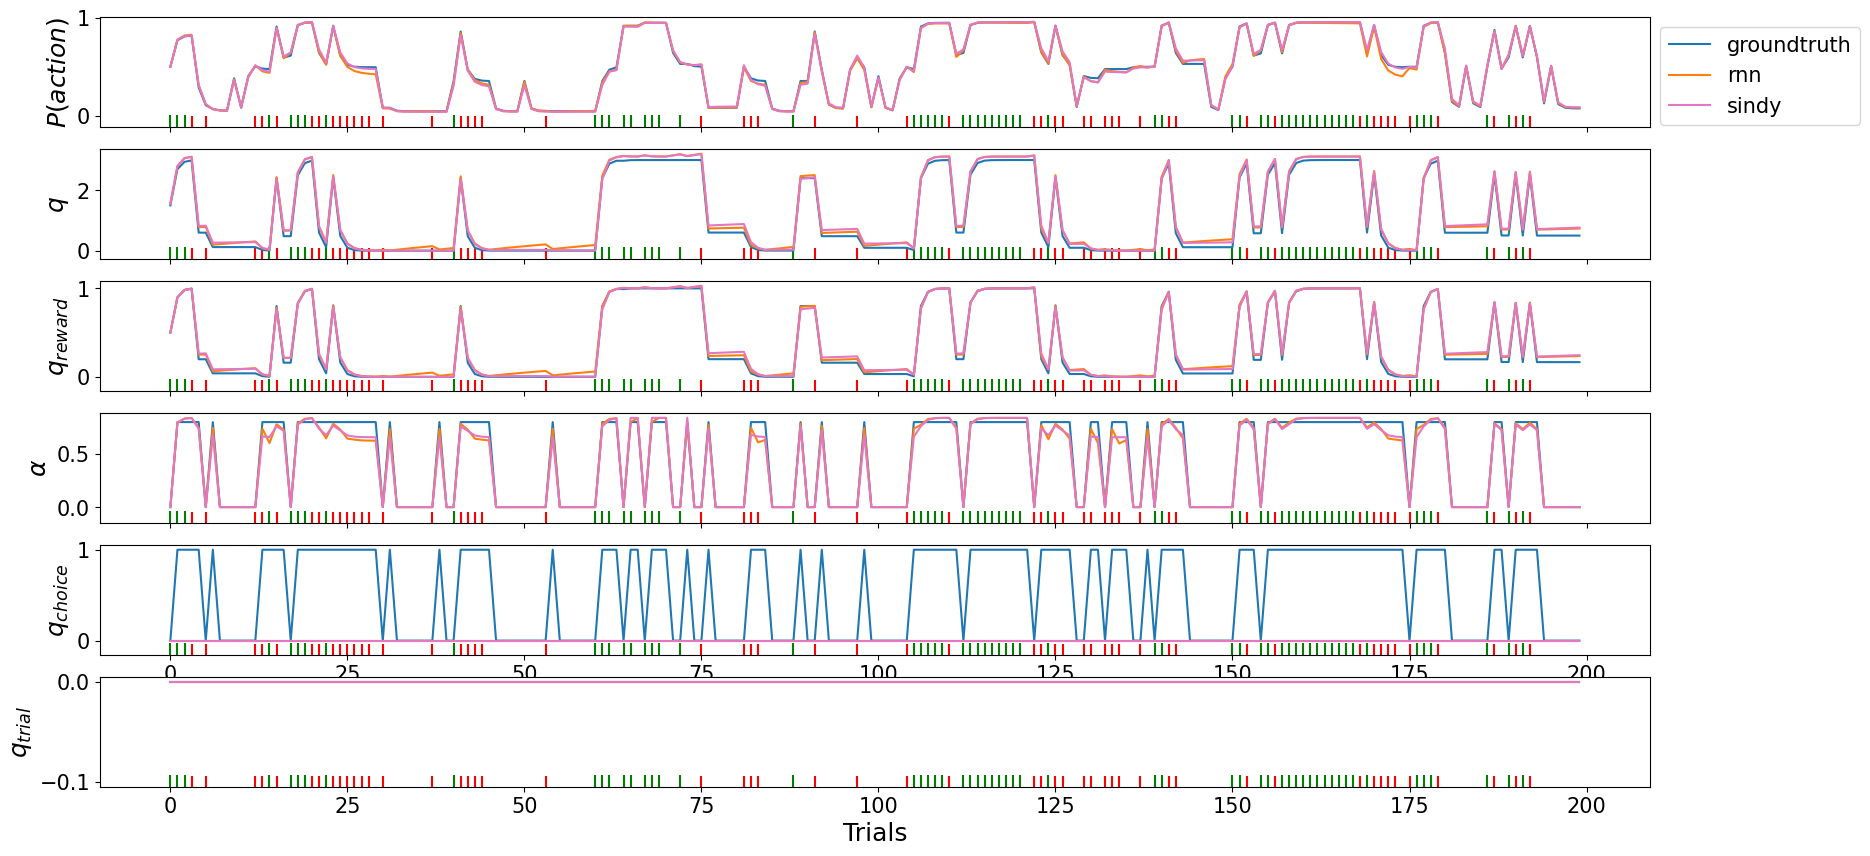

In [17]:
from spice.utils.plotting import plot_session

# get analysis plot
agents = {'groundtruth': agent_1, 'rnn': spice_estimator.rnn_agent, 'sindy': spice_estimator.spice_agent}

fig, axs = plot_session(agents, dataset.xs[0])
plt.show()

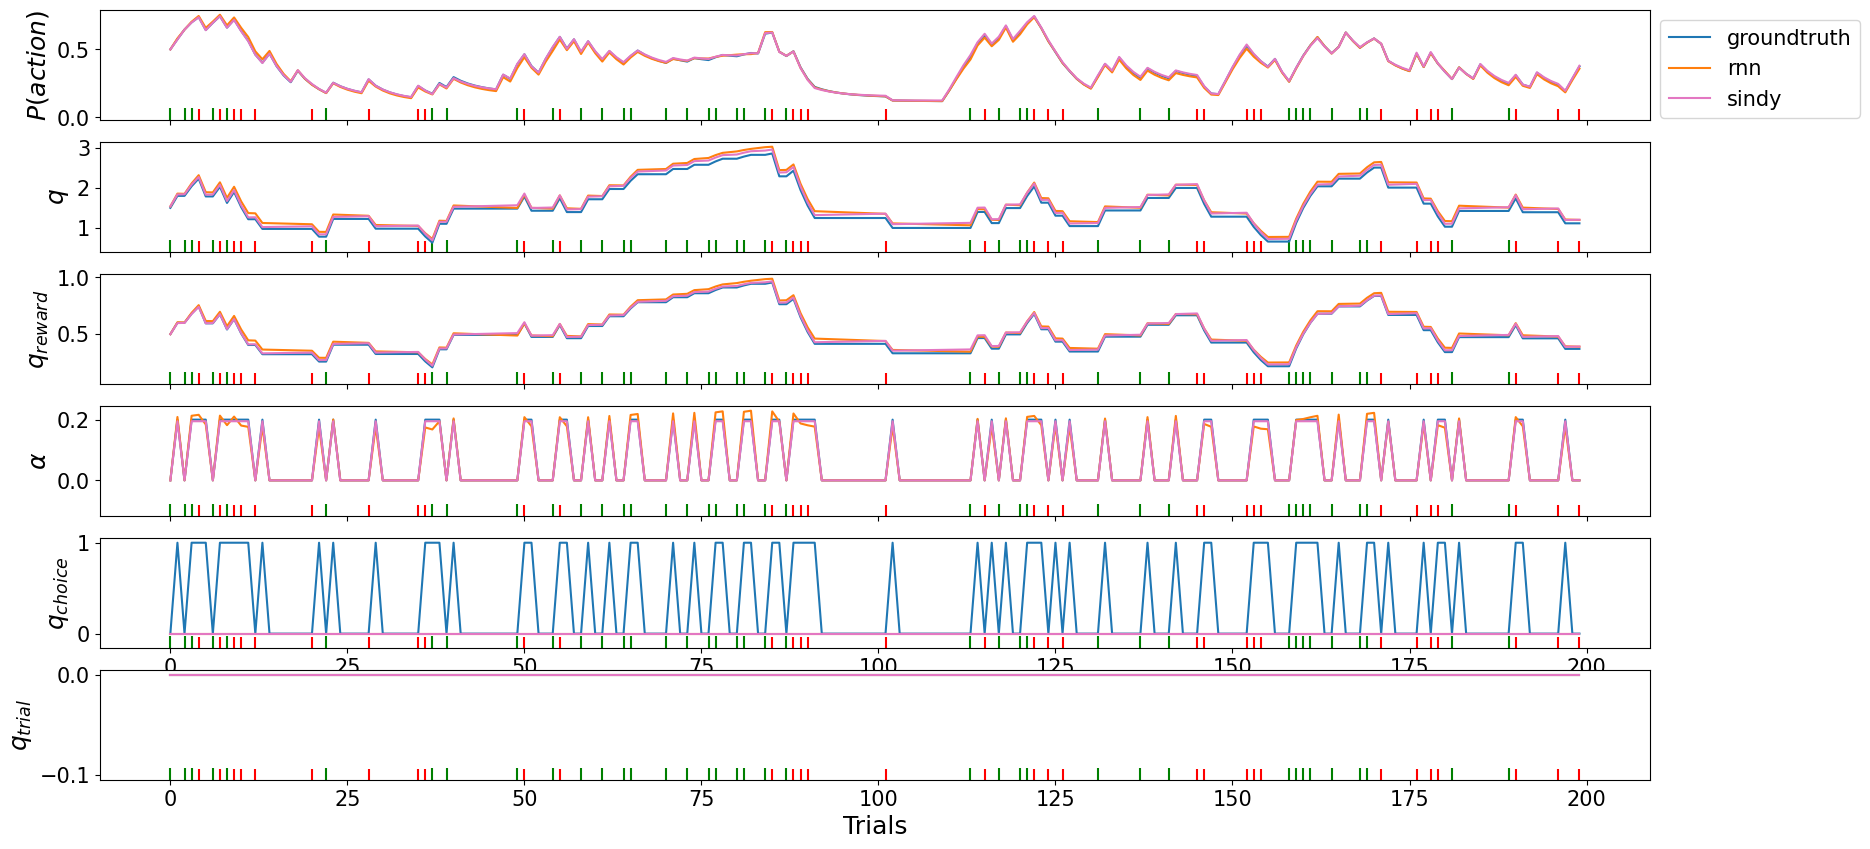

In [18]:
from spice.utils.plotting import plot_session

# get analysis plot
agents = {'groundtruth': agent_2, 'rnn': spice_estimator.rnn_agent, 'sindy': spice_estimator.spice_agent}

fig, axs = plot_session(agents, dataset_2.xs[0])
plt.show()

Now that we are making use of the established theories about the reward-prediction error in human reinforcement learning, we were able to to shift our focus on a less understood area i.e. the learning rate. In this example, the synthetic participant does not exhibit real dynamics in the sense of $\alpha_{t+1} = f(\alpha_{t})$, but the network is in principle equipped to learn also such a mechanism.